# Загрузка необходимых библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import urllib.request

In [2]:
def print_nominative_stat(column, dropna_value=True):
    """ Функция принимает столбец с номинативными признаками и
        признак подсчёта пропущенных значений. 
        Печатает информацию о количестве каждого признака в столбце, его процентное
        содержание и общее количество всех признаков.
    """

    norm = pd.DataFrame(column.value_counts(
        dropna=dropna_value, normalize=True))
    unnorm = pd.DataFrame(column.value_counts(dropna=dropna_value))
    unnorm.columns = ['number']
    unnorm.loc[:, 'percent'] = round(norm[norm.columns[0]]*100, 1)
    unnorm.loc['Total:'] = unnorm[['number', 'percent']].sum()
    print(unnorm, '\n')

In [3]:
def numeric_column_info(column, column_name='Data', bounds=()):
    """ Функция принимает столбец с числовым признаком, его имя 
        и предполагаемые границы изменения для отбора выбросов.
        Если границы не указаны, то отбор по IQR.
        Печатает статистические характеристики и 
        информацию о выбросах, а также рисует гистограмму распределения признака
    """
    if bounds == ():
        out_type = 'IQR'
    else:
        out_type = 'Bounds'

    values = column.count()
    null_values = column.isnull().sum()
    max_value = column.max()
    min_value = column.min()
    mean_value = round(column.mean(), 1)
    std_value = round(column.std(), 2)
    perc25 = column.quantile(0.25)
    perc50 = column.quantile(0.50)
    perc75 = column.quantile(0.75)
    IQR = column.quantile(0.75) - column.quantile(0.25)

    if out_type == 'IQR':
        left_bound = perc25 - 1.5*IQR
        right_bound = perc75 + 1.5*IQR
    elif out_type == 'Bounds':
        left_bound = bounds[0]
        right_bound = bounds[1]
    else:
        print('Unknown out_type')

    out_lower = column.loc[column < left_bound].value_counts().sum()
    out_upper = column.loc[column > right_bound].value_counts().sum()
    total_out = out_lower + out_upper
    print(f'Признак {column_name}:\n\nВсего записей: {values}\nПропущенных (null): {null_values}\n'
          f'Максимум: {max_value}\n75-й перцентиль: {perc75}\n50-й перцентиль: {perc50}\n25-й перцентиль: {perc25}\n'
          f'Минимум: {min_value}\nСреднее арифм.: {mean_value}\nСКО: {std_value}\n'
          f'IQR: {IQR}\nГраницы валидных данных: [{left_bound},{right_bound}]')

    column.loc[column.between(left_bound, right_bound)].hist(
        bins=40,
        range=(min_value, max_value),
        label=column_name + ' valid')
    if total_out == 0:
        print('\033[1;32;43mВыбросов по ' + out_type + ' не обнаружено')
    else:
        print('\033[1;31;43mОбнаружены выбросы по ' + out_type)
        print(
            f'Выбросов: {total_out}\nСверху: {out_upper}\nСнизу: {out_lower}')
        column.loc[~column.between(left_bound, right_bound)].hist(
            bins=40,
            range=(min_value, max_value),
            label=column_name + ' outlayers')
    plt.legend()

Загрузим данные и взглянем на них:

In [3]:
df = pd.read_csv('main_task.csv')

In [4]:
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Первое приближение

Датасет изначально содержит 3 числовые переменные - [Ranking], [Rating], [Number of Reviews]. Видим, что 3 столбца из 10 содержат пропуски. 

Для начала посмотрим на распределение [Ranking] - место, которое занимает ресторан среди всех ресторанов своего города.

Видим, что выбросы и пропущенные значения отсутствуют. 

Признак Ranking:

Всего записей: 40000
Пропущенных (null): 0
Максимум: 16444.0
75-й перцентиль: 5260.0
50-й перцентиль: 2285.0
25-й перцентиль: 973.0
Минимум: 1.0
Среднее арифм.: 3676.0
СКО: 3708.75
IQR: 4287.0
Границы валидных данных: [0,20000]
Выбросов по Bounds не обнаружено


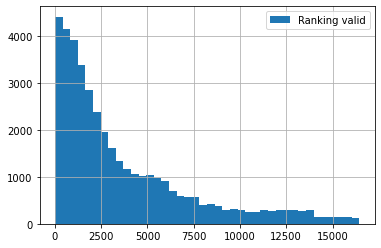

In [7]:
numeric_column_info(df['Ranking'],
                    column_name='Ranking', bounds=(0, 20000))

Столбец [Rating] - это целевая переменная модели, которая показывает рейтинг ресторана на TripAdvisor. 

Из распределения можно сделать вывод, что примерно четверть ресторанов имеет рейтинг ниже 3.5 баллов, такое же количество ресторанов имеет рейтинг выше 4.5 баллов.

Оставшаяся половина имеет рейтинг в диапазоне от 3.5 до 4.5 баллов. Среднее значение совпадает с медианным и равно 4 баллам.

Признак Rating:

Всего записей: 40000
Пропущенных (null): 0
Максимум: 5.0
75-й перцентиль: 4.5
50-й перцентиль: 4.0
25-й перцентиль: 3.5
Минимум: 1.0
Среднее арифм.: 4.0
СКО: 0.67
IQR: 1.0
Границы валидных данных: [1,5]
Выбросов по Bounds не обнаружено


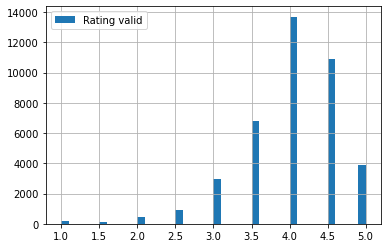

In [8]:
numeric_column_info(df['Rating'],
                    column_name='Rating', bounds=(1, 5))

Столбец [Number of Reviews] содержит общее число отзывов. Заметим, что в нём есть небольшое количество пропусков (6%), которое можно заполнить рзличными способами. 

К сожалению, я пока не разобрался с тем, как достать эту информацию с сайта, поэтому восполним пропущенные значения нулём, так, как-будто отзывов нет совсем. 

Стоит отметить, что эксперименты с заполнением средним, медианным и минимальным значениями не оказывали значительного влияния на целевую метрику MAE. 

Признак Number of Reviews:

Всего записей: 37457
Пропущенных (null): 2543
Максимум: 9660.0
75-й перцентиль: 115.0
50-й перцентиль: 33.0
25-й перцентиль: 9.0
Минимум: 2.0
Среднее арифм.: 124.8
СКО: 295.67
IQR: 106.0
Границы валидных данных: [0,10000]
Выбросов по Bounds не обнаружено


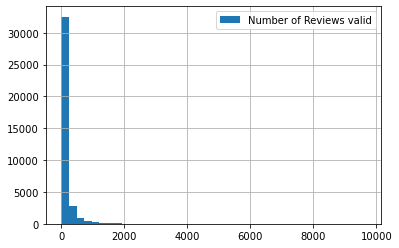

In [9]:
numeric_column_info(df['Number of Reviews'],
                    column_name='Number of Reviews', bounds=(0, 10000))

In [10]:
df['Number of Reviews'] = df[['Number of Reviews']].fillna(0)

Сохраним набор данных [Ranking], [Rating], [Number of Reviews] и используем его для первого приближения (iteration#1)

In [11]:
df[['Ranking', 'Rating', 'Number of Reviews']].to_csv(
    'iteration#1.csv', index=False)

Результат (метрика MAE), полученный при использовании данных (iteration#1): **0.425**.

# Второе приближение, Feature Engineering

Попробуем улучшить результат, используя другие данные из датафрейма. 

Для этого преобразуем такие переменные как [Price Range], [City] и [Cuisine Style] к числовому виду. 

Столбец [Price Range] содержит в себе ценовой диапазон блюд, предлагаемых в ресторане. 

Всего возможно три варианта значений: 

'S' - дешёвые блюда (16%), 

'SS - SSS' - блюда средней ценовой категории (46%),

'SSSS' - дорогие блюда (4%). 

Отметим наличие пропущенных записей (35%). Восполним их наиболее часто встречающимся ценовым диапазоном 'SS - SSS'.
  

In [12]:
print_nominative_stat(df['Price Range'], dropna_value=False)

           number  percent
$$ - $$$  18412.0     46.0
NaN       13886.0     34.7
$          6279.0     15.7
$$$$       1423.0      3.6
Total:    40000.0    100.0 



In [13]:
def fill_price(row):
    """ Функция принимает строку датафрейма и производит замену в Price Range по правилу:
        '$' -> 0;  NaN, '$$ - $$$' -> 1,  '$$$$' -> 2
    """
    if pd.isnull(row['Price Range']):
        return 1
    elif row['Price Range'] == '$':
        return 0
    elif row['Price Range'] == '$$ - $$$':
        return 1
    else:
        return 2

In [14]:
df['Price'] = df.apply(fill_price, axis=1)

Заметим, что такая замена вполне обоснована, так как между этими категориями имеется отношение порядка. 

Далее преобразуем столбец [City] в числовой признак, сопоставив каждому городу его долю вхождений в датасет. Для начала создадим словарь Город: доля в данных.

In [15]:
city_part = df.City.value_counts(dropna=False, normalize=True).to_dict()

In [16]:
def fill_city(row):
    """ Функция принимает строку и заменяет значение в поле City
         на долю вхождений данного города в датасет, используя словарь
    """
    return city_part[row['City']]

In [17]:
df['City Part'] = df.apply(fill_city, axis=1)

Столбец [Ranking] содержит в себе рейтинг ресторана среди всех ресторанов города, в котором он находится. Заметим, что быть, например, 3 из 20 совсем не то же самое, что 3 из 40. 

Поэтому нужно определить какое-то взвешенное значение, которое будет определять новый "рейтинг", принимая во внимание количество записей о кокретном городе в датасете. 

Рассмотрим следующее преобразование. Пусть N_i - количество записей в датасете о городе i. Рейтинг города i по своему смыслу должен меняться от 1 до N_i. 

Введем линейное преобразование, которое переведет рейтинг 1 -> 1 (лучший ресторан города), а рейтинг N_i -> 0 (худший ресторан города).

Построим новый признак по правилу: y_i = (ranking - N_i)/(1 - N_i). Таким образом, ожидаем, что значения [Ranking] отобразятся на отрезок [0;1]. 

Умножим y_i на [City Part]~[0;1], определив тем самым взвешенный рейтинг. 

Для начала построим словарь Город: число вхождений в датасет

In [18]:
city_in = df.City.value_counts(dropna=False).to_dict()

In [19]:
def fill_ranking(row):
    return (row['Ranking']-city_in[row['City']])/(1-city_in[row['City']])*row['City Part']

In [20]:
df['City Ranking 1'] = df.apply(fill_ranking, axis=1)

Признак City Ranking 1:

Всего записей: 40000
Пропущенных (null): 0
Максимум: 0.143925
75-й перцентиль: 0.009429949564037076
50-й перцентиль: -0.014910621842810074
25-й перцентиль: -0.05332516550312951
Минимум: -0.26722141678248784
Среднее арифм.: -0.0
СКО: 0.07
IQR: 0.06275511506716659
Границы валидных данных: [0,1]
Обнаружены выбросы по Bounds
Выбросов: 26191
Сверху: 0
Снизу: 26191


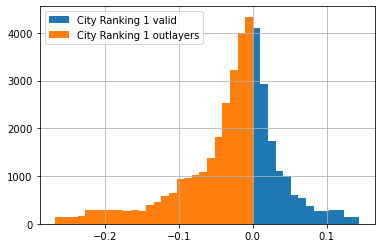

In [21]:
numeric_column_info(df['City Ranking 1'],
                    column_name='City Ranking 1', bounds=(0, 1))

Построенное распределение нового признака с ожидаемыми границами bounds [0;1] показывает, что в признаке содержатся отрицательные значения. Это произошло потому, что датасет содержит лишь выборку из ресторанов, такую, что рейтинг может превышать число записей о ресторанах в конкретном городе, тогда числитель в формуле преобразования станет положительным. Так как знаменатель формулы всегда отрицателен для нашего датасета, появляются отрицательные значения. 

Попробуем ввести новый признак [City Ranking], который бы учитывал количество ВСЕХ записей о ресторанах города на TripAdvisor. (Сборка данных для 31 города была произведена вручную)

In [22]:
total = [16744, 15242, 10000, 8578, 5965, 6536, 9925, 4559, 4391, 3702, 3602, 2345, 2838, 2831,
         2478, 2657, 2690, 2673, 2054, 1982, 2241, 1706, 1643, 1778, 1358, 1446, 1220, 1336, 1016, 650, 530]
city_in_all = dict(zip(list(city_in.keys()), total))
tot_data = sum(total)

In [23]:
def fill_ranking_all(row):
    return (row['Ranking']-city_in_all[row['City']])/(1-city_in_all[row['City']])*(city_in_all[row['City']]/tot_data)

In [24]:
df['City Ranking 2'] = df.apply(fill_ranking_all, axis=1)

Признак City Ranking 2:

Всего записей: 40000
Пропущенных (null): 0
Максимум: 0.1321380094068626
75-й перцентиль: 0.050780048928956656
50-й перцентиль: 0.022022001631269376
25-й перцентиль: 0.009973882622425158
Минимум: -0.005202824768337936
Среднее арифм.: 0.0
СКО: 0.03
IQR: 0.0408061663065315
Границы валидных данных: [0,1]
Обнаружены выбросы по Bounds
Выбросов: 482
Сверху: 0
Снизу: 482


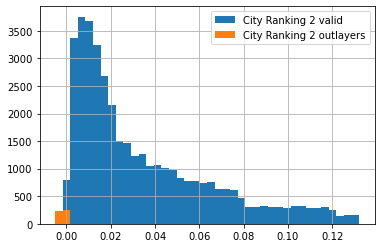

In [25]:
numeric_column_info(df['City Ranking 2'],
                    column_name='City Ranking 2', bounds=(0, 1))

К сожалению, полностью избежать отрицательных значений не удалось. Несмотря на это, оставим признак и посмотрим на значение коэффициента корреляции двух полученных рейтингов с [Ranking] и друг с другом. 

In [26]:
df['Ranking'].corr(df['City Ranking 2'])

0.04264358867318744

Корреляция [Ranking] и [City Ranking 2] почти нулевая (0.0426) и между ними нет линейной связи, таким образом, оба этих признака можно включить в модель вместе.

In [27]:
df['Ranking'].corr(df['City Ranking 1'])

-0.8762516949955924

Корреляция [Ranking] и [City Ranking 1] сильная и отрицательная (-0.8762). Скорее всего, оба этих признака включать в модель не имеет смысла. 

In [28]:
df['City Ranking 2'].corr(df['City Ranking 1'])

0.43174719293909364

Корреляция [City Ranking 1] и [City Ranking 2] умеренная и положительная (0.4317). Скорее всего, оба этих признака можно включать в модель. 

Преобразуем столбец [Cuisine] к числовому виду. Для этого вычислим, сколькими разновидностями кухонь представлен датасет:

In [29]:
dfnot = df[~df['Cuisine Style'].isna()]
all_cuisine = set()
for c_list in dfnot['Cuisine Style']:
    a = c_list.split('[')[1].split(']')[0].split(', ')
    for cuisine in a:
        all_cuisine.add(cuisine.split("'")[1])
N_cuisine = len(all_cuisine)

Оказалось, что всего имеется 125 разновидностей кухонь. Выясним сколько кухонь предлагается в каждом ресторане, предполагая, что если информация осутствует (почти 9 тысяч записей), то в ресторане имеется 1 кухня.

In [78]:
cuisine_num = []
for c_list in df['Cuisine Style']:
    if isinstance(c_list, float) and math.isnan(c_list):
        cuisine_num.append(1)
    else:
        cuisine_num.append(len(c_list.split('[')[1].split(']')[0].split(', ')))

In [31]:
cuisine_num = pd.Series(cuisine_num)
cuisine_num.value_counts(normalize=True)

1     0.413675
2     0.157350
3     0.132650
4     0.119975
5     0.090150
6     0.051075
7     0.025550
8     0.007075
9     0.001900
10    0.000475
11    0.000075
21    0.000025
13    0.000025
dtype: float64

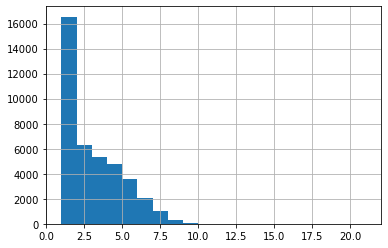

In [32]:
cuisine_num.hist(bins=20)

In [33]:
mean_cuisine = cuisine_num.mean()
mean_cuisine

2.6224

Отметим, что в среднем в ресторане предлагается около трех кухонь (2.6224). 41% ресторанов предлагает 1 тип кухни. Введем новый признак [Cuisine Norm], показывающий отклонение числа кухонь, представленных в ресторане от среднего числа кухонь по всем ресторанам. Нормируем признак на общее количество возможных кухонь. 

In [34]:
df['Cuisine Norm'] = (cuisine_num-mean_cuisine)/N_cuisine

Признак Cuisine Norm:

Всего записей: 40000
Пропущенных (null): 0
Максимум: 0.1470208
75-й перцентиль: 0.0110208
50-й перцентиль: -0.004979199999999999
25-й перцентиль: -0.012979199999999998
Минимум: -0.012979199999999998
Среднее арифм.: 0.0
СКО: 0.01
IQR: 0.024
Границы валидных данных: [-1,1]
Выбросов по Bounds не обнаружено


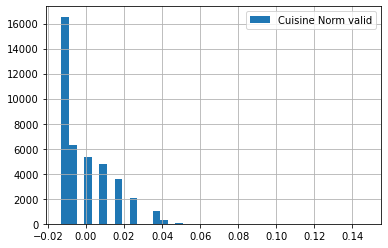

In [35]:
numeric_column_info(df['Cuisine Norm'],
                    column_name='Cuisine Norm', bounds=(-1, 1))

Выясним также, какая именно кухня представлена в наибольшем количестве ресторанов (выведем первую тройку лидеров)

In [36]:
dictOfCuisine = dict(zip(all_cuisine, [0 for i in range(len(all_cuisine))]))

dfnot = df[~df['Cuisine Style'].isna()]
for c_list in dfnot['Cuisine Style']:
    a = c_list.split('[')[1].split(']')[0].split(', ')
    for cuisine in a:
        dictOfCuisine[cuisine.split("'")[1]] += 1

sort_orders = sorted(dictOfCuisine.items(), key=lambda x: x[1], reverse=True)
for i in sort_orders[0:3]:
    print(i[0], i[1], sep=': ')

Vegetarian Friendly: 11189
European: 10060
Mediterranean: 6277


Еще одним возможным числовым признаком может быть признак количества дней [Days], прошедших с момента написания последнего отзыва, а также наибольшая разница в днях между отзывами [Dif Days].

В ходе работы удалось собрать данные по всем 40000 ресторанам с сайта TripAdvisor. К сожалению, информация была собрана не по всем отзывам, а только по 10 самым свежим. 

Это никак не сказывается на признаке [Days], но сказывается на [Dif Days]. Ниже представлен код, который собирал данные (не стоит запускать - долгое время работы): 

Отметим, что время работы кода составило около полутора суток. Данные были сохранены в файлы. 

Создадим новый признак [Days], содержащий количество дней с момента последнего отзыва. Загрузим данные и вычислим разницу между текущей датой и временем последнего отзыва. Отобразим данные и заполним пропуски средним значением. 

In [5]:
with open("last_rev.txt", "rb") as fp:
    data = pickle.load(fp)

In [38]:
today = '2020-06-13'
today = datetime.strptime(today, '%Y-%m-%d')

In [39]:
days_dif = []
for cur_day in data:
    try:
        days_dif.append((today-cur_day).days)
    except:
        days_dif.append(None)

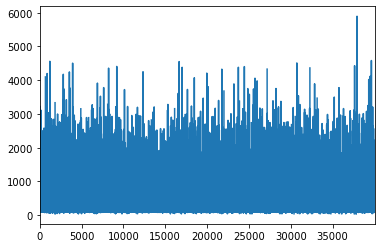

In [40]:
pd.Series(days_dif).plot()

In [41]:
days_dif = pd.Series(days_dif)

In [42]:
days_dif.isna().sum()

2894

In [43]:
days_dif = days_dif.fillna(days_dif.mean())

In [44]:
df['Days'] = days_dif

Аналогично сформируем признак [Dif Days], загрузив собранные данные. 

In [45]:
with open("max_dif.txt", "rb") as fp:
    data = pickle.load(fp)

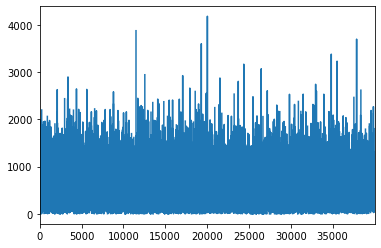

In [46]:
data = pd.Series(data)
data.plot()
data = data.fillna(data.mean())

In [47]:
df['Dif Days'] = data

Сохраним полученный набор данных [Price], [City Part], [City Ranking 1], [City Ranking 2], [Cuisine Norm], 
[Days], [Dif Days] оставив при этом данные [Ranking], [Rating], [Number of Reviews] с первой итерации. 

In [48]:
df = df.drop(['Restaurant_id', 'City', 'Cuisine Style',
              'Price Range', 'Reviews', 'URL_TA', 'ID_TA'], axis=1)

In [49]:
df.to_csv('iteration#2.csv', index=False)

In [50]:
df.head(5)

,Ranking,Rating,Number of Reviews,Price,City Part,City Ranking 1,City Ranking 2,Cuisine Norm,Days,Dif Days
0,5570.0,3.5,194.0,1,0.122425,-0.016828,0.076333,0.003021,120.0,1440.0
1,1537.0,4.0,10.0,1,0.020500,-0.017947,0.008842,-0.012979,107.0,965.0
2,353.0,4.5,688.0,2,0.143925,0.135123,0.129360,0.035021,308.0,627.0
3,3458.0,5.0,3.0,1,0.053875,-0.032590,0.019788,-0.012979,1575.0,1387.0
4,621.0,4.0,84.0,1,0.022325,0.006808,0.017447,0.003021,259.0,556.0


Результат (метрика MAE), полученный при использовании данных (iteration#2): **0.21**, что значительно улучшает предыдущий результат

# Третье приближение, Dummy Variables

In [58]:
df = pd.read_csv('main_task.csv')

Можем преобразовать [City] в Dummy Variables:

In [128]:
city_dummy = pd.get_dummies(df[['City']])
city_dummy.to_csv('city_dummy.csv', index=False)
city_dummy.head(5)

,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Как и ожидалось, получился ровно 31 новый признак по количеству городов в датасете.

Для преобразования [Cuisine Style] в Dummy Variables нужно для начала подготовить данные, заменив пропущенные значения на самое популярную кухню 'Vegetarian Friendly', а затем освободиться от скобок и апострофов (код работает не мгновенно, поэтому результат был сохранён):

In [116]:
cuisine_dummy = pd.read_csv('cuisine_dummy.csv')
cuisine_dummy.head(5)

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Как и ожидалось, получилось еще 125 признаков по количеству кухонь в датасете

Все дальнейшие действия и результаты описаны в файле Modelling